In [125]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import time

In [126]:
class HandleConeImage:
    def __init__(self):
        self.leftBBImage = []
        self.rightBBImage = []
        
    def readImage(self,imagePath):
        image = cv2.imread(imagePath)
        self.leftBBImage = np.zeros(image.shape, dtype=np.uint8)
        self.rightBBImage = np.zeros(image.shape, dtype=np.uint8)
        return image
    
    def getGreyScaleImage(self, image):
        grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return grey
    
    def getRGBImage(self, image):
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return rgb
    
    def getHSVImage(self, image):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return hsv
    
    def getBoundingBoxImage(self, imageLeft, imageRight, topLeft, bottomRight):
        leftBB = np.zeros(imageLeft.shape, dtype=np.uint8)
        rightBB = np.zeros(imageRight.shape, dtype=np.uint8)
        
        leftBB = imageLeft[74:382, 455:700]
        rightBB = imageRight[topLeft[1]:bottomRight[1], topLeft[0]:bottomRight[0]]
        return leftBB, rightBB
    
    def applyMaskOnConeImage(self, image):
        greenThreshold = cv2.inRange(image, np.array([60, 60, 60]), np.array([90, 255, 255]))
        whiteThreshold = cv2.inRange(image, np.array([0, 0, 180]), np.array([180, 30, 255]))
        combinedThreshold = cv2.bitwise_or(greenThreshold, whiteThreshold)
        return combinedThreshold
    
    def getMaskedImage(self, leftMask, rightMask):
        kernel = np.ones((5, 5))
        openedLeft = cv2.morphologyEx(leftMask, cv2.MORPH_OPEN, kernel)
        openedRight = cv2.morphologyEx(rightMask, cv2.MORPH_OPEN, kernel)
        maskLeft = np.zeros(leftMask.shape, dtype=np.uint8)
        maskRight = np.zeros(rightMask.shape, dtype=np.uint8)
        
        maskLeft[openedLeft > 0] = 255
        maskRight[openedRight > 0] = 255
        
        return maskLeft, maskRight
    
    def setBBImages(self, leftMask, rightMask):
        self.leftBBImage[74:382, 455:700] = leftMask
        self.rightBBImage[right_tl[1]:right_br[1], right_tl[0]:right_br[0]] = rightMask
        
    

In [129]:
class StereoImageProcessing:
    def __init__(self, imageLeft, imageRight):
        self.imageLeft = imageLeft
        self.imageRight = imageRight
        self.projectionMatrixLeft = np.zeros((3,4))
        self.projectionMatrixRight = np.zeros((3,4))
        self.KMatrixLeft = self.CreateKMatrix(699.624, 645.571, 342.463)
        self.KMatrixRight = self.CreateKMatrix(700.831, 633.652, 377.025)
        self.triangulated3DPoints = []
        self.setProjectionMatrices()
        
    def setProjectionMatrices(self):
        rotationTranslationLeft = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
        rotationTranslationRight = np.array([[1,0,0,120],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
        homogeneousMatrix = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
        self.projectionMatrixLeft = self.KMatrixLeft @ homogeneousMatrix @ rotationTranslationLeft
        self.projectionMatrixRight = self.KMatrixRight @ homogeneousMatrix @ rotationTranslationRight
        
        
    def getMatchingPoints(self, leftMask, rightMask):
        orb = cv2.ORB_create()
        kpl = orb.detect(self.imageLeft, leftMask)
        kpr = orb.detect(self.imageRight, rightMask)        

        kpl, des1 = orb.compute(self.imageLeft, kpl)
        kpr, des2 = orb.compute(self.imageRight, kpr)
        
        matcher = cv2.BFMatcher()
        matched_keypoints = matcher.knnMatch(des1,des2,k=2)
        
        good = []
        matchesMask = [[0,0] for i in range(len(matched_keypoints))]
        
        # ratio test as per Lowe's paper
        for i, (m,n) in enumerate(matched_keypoints):
            good.append(m)
            matchesMask[i]=[1,0]
            
        draw_params = dict(matchColor = (0,255,0), singlePointColor = (255,0,0), matchesMask = matchesMask, flags = 0)
                
        source_pts = np.float32([ kpl[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        destination_pts = np.float32([ kpr[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        source_pts = source_pts.reshape(1, source_pts.shape[0], 2)
        destination_pts = destination_pts.reshape(1, destination_pts.shape[0], 2)
        
#         featureMatch = cv2.drawMatchesKnn(self.imageLeft,kpl,self.imageRight,kpr,matched_keypoints,None,**draw_params)
#         cv2.imwrite('featureMatch.jpg',featureMatch)
        
        return source_pts, destination_pts
    
    def CreateKMatrix(self, focalLength, Cx, Cy):
        KMatrix = np.array([[focalLength, 0.0000, Cx],[0.0000, focalLength, Cy],[0.0000, 0.0000, 1.0000]], dtype=np.float32)
        return KMatrix
    
    def getFundamentalMatrix(self):
        KMatLeft_Inv = np.linalg.inv(self.KMatrixLeft)
        KMatRight_Inv = np.linalg.inv(self.KMatrixRight)
        KMatRight_Inv_Transpose = KMatRight_Inv.transpose()

        translation = np.array([[0,0,0],[0,0,-120],[0,120,0]])
        rotation = np.identity(3)

        fundamentalMatrix = KMatRight_Inv_Transpose @ translation @ rotation @ KMatLeft_Inv
        
        return fundamentalMatrix
    
    def triangulateMatchedPoints(self, sourcePoints, destinationPoints):
        ThreeDPoints = cv2.triangulatePoints(self.projectionMatrixLeft, self.projectionMatrixRight, sourcePoints, 
                                             destinationPoints)
        ThreeDPoints = ThreeDPoints.T
        self.triangulated3DPoints = np.array([x/x[3] for x in ThreeDPoints if np.linalg.norm(x/x[3]) < 1200]) 
#         print("Triangulated points",self.triangulated3DPoints)
        
    def plot3DPoints(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(self.triangulated3DPoints[:, 2], self.triangulated3DPoints[:, 0], self.triangulated3DPoints[:, 1])

        xCentroid = np.mean(self.triangulated3DPoints[:, 2],dtype=np.float64)
        yCentroid = np.mean(self.triangulated3DPoints[:, 0],dtype=np.float64)
        zCentroid = np.mean(self.triangulated3DPoints[:, 1],dtype=np.float64)
        
        print("The centroid of the cone is", xCentroid, yCentroid, zCentroid)
        ax.scatter(xCentroid, yCentroid, zCentroid, color ="red")
        plt.show()
    


The execution time for proceesing one cone is--- 0.11173868179321289 seconds ---
The centroid of the cone is -760.2704399510434 58.944545874078024 149.50705597745744


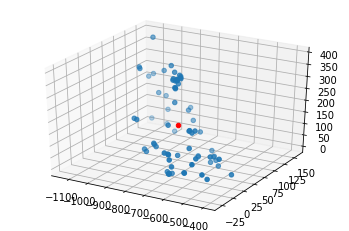

In [130]:
if __name__=='__main__':
    start_time = time.time()
    cone = HandleConeImage()
    leftImage = cone.readImage("left.png")
    rightImage = cone.readImage("right.png")
    
    rightTopLeft = (1174 - (leftImage.shape[1] - 455), 74) 
    rightBottomRight = (1174 - (leftImage.shape[1] - 700), 382) 
    
    leftBB, rightBB = cone.getBoundingBoxImage(leftImage, rightImage, rightTopLeft, rightBottomRight)
    
    leftHSV = cone.getHSVImage(cone.getRGBImage(leftBB))
    righttHSV = cone.getHSVImage(cone.getRGBImage(rightBB))
    
    leftMask = cone.applyMaskOnConeImage(leftHSV)
    rightMask = cone.applyMaskOnConeImage(righttHSV)
    
    
    leftMaskedImage, rightMaskedImage = cone.getMaskedImage(leftMask, rightMask)
    
    leftGreyImageMask = np.zeros(cone.getGreyScaleImage(leftImage).shape, dtype=np.uint8)
    rightGreyImageMask = np.zeros(cone.getGreyScaleImage(rightImage).shape, dtype=np.uint8)
    
    leftGreyImageMask[74:382, 455:700] = leftMaskedImage
    rightGreyImageMask[rightTopLeft[1]:rightBottomRight[1], rightTopLeft[0]:rightBottomRight[0]] = rightMaskedImage
    
    #stereo matching
    stereo = StereoImageProcessing(cone.getGreyScaleImage(leftImage), cone.getGreyScaleImage(rightImage))
    source_pts, destination_pts = stereo.getMatchingPoints(leftGreyImageMask, rightGreyImageMask)
    
    source_pts, destination_pts = cv2.correctMatches(stereo.getFundamentalMatrix(), source_pts, destination_pts)
    stereo.triangulateMatchedPoints(source_pts, destination_pts)
    print("The execution time for proceesing one cone is--- %s seconds ---" % (time.time() - start_time))
    stereo.plot3DPoints()
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()